# Experiments with WCDS
In this notebook are all experiments that are done using WCDS.

In [1]:
%matplotlib notebook
from wcds.wcds import WCDS
import time
from sklearn.datasets import *
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math

## Datasets
In the following sections datastream will be the variable where the used datastream is saved in.

In [2]:
# Complex8 Dataset
url = "http://www2.cs.uh.edu/~ml_kdd/restored/Complex&Diamond/Complex8.data"
complex8 = pd.read_csv(url)
data = complex8
x = data["563.225"]
y = data["56.748"]
x = list(x / 675) #Normalizing between [0:1]
y = list(y / 401) #Normalizing between [0:1]
data = list(zip(x,y))
np.random.shuffle(data) #Shuffle order
datastream = list(zip(data, list(range(len(data)))))

In this case we are using the sliding window model with the sw discriminators and sw neurons.

In [3]:
%%time
# Stream clustering (online clustering only)

OMEGA = 3000 # For batch clustering has to be over 2500
DELTA = 200
GAMMA = 500
EPSILON = 0.8
µ = 1

clusterer = WCDS(
    omega=OMEGA,
    delta=DELTA,
    gamma=GAMMA,
    epsilon=EPSILON,
    dimension=len(datastream[0][0]),
    µ=µ)

predictions = []
for i in datastream:
    obs, time_ = i
    k = clusterer.record(obs, time_)
    predictions.append(k)

Wall time: 2min 7s


In [4]:
%%time
from wcds.clusterers import AgglomerativeClustering

agg = AgglomerativeClustering()
actual_clusters = agg.fit(clusterer.discriminators, n_clusters=8)
print(actual_clusters)

[{129, 130, 5, 133, 138, 12, 141, 15, 16, 148, 27, 29, 162, 36, 165, 164, 41, 43, 172, 173, 178, 52, 184, 61, 63, 71, 75, 76, 77, 82, 83, 87, 91, 92, 100, 109, 113, 120, 121}, {32, 160, 2, 99, 39, 143, 50, 115, 158, 62, 31}, {0, 72, 136, 139, 19, 84, 21, 88, 26, 159, 170, 106, 174, 177, 114, 51, 183, 56, 122, 60}, {131, 4, 134, 7, 8, 9, 137, 13, 14, 145, 18, 146, 20, 149, 150, 23, 151, 152, 25, 155, 156, 157, 30, 154, 161, 35, 37, 166, 168, 42, 171, 44, 45, 46, 48, 176, 179, 181, 54, 55, 64, 67, 74, 79, 85, 86, 89, 94, 96, 97, 101, 104, 105, 108, 111, 112, 117, 118, 119, 124, 125, 127}, {10, 142, 144, 22, 98, 38, 103, 40, 169, 107, 123, 110, 182, 58, 59}, {128, 65, 66, 68, 132, 6, 69, 135, 11, 78, 81, 17, 153, 95, 34, 163, 102, 175, 47, 53}, {24, 73, 116, 93}, {1, 3, 70, 140, 80, 147, 90, 28, 57, 33, 167, 49, 180, 185, 126}]
Wall time: 24.8 s


In [5]:
print(len(actual_clusters))

8


In [ ]:
clusterer.save("wcds.json")

## Plot results

<IPython.core.display.Javascript object>


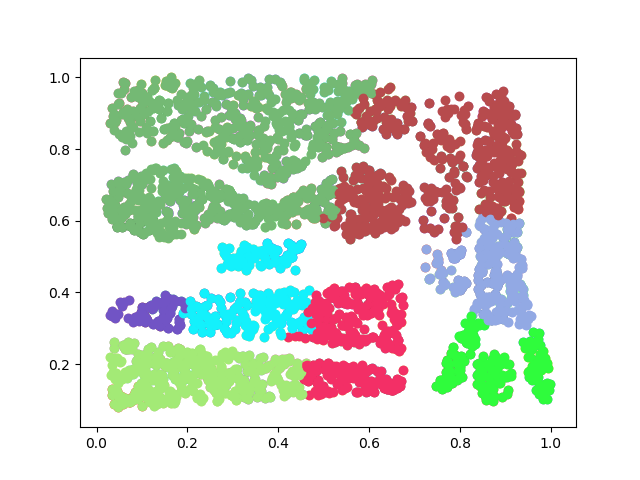

Found 186 Clusters.


In [6]:
# Plot results

number_of_colors = max(predictions)+1
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]
color_dict = {key: value for (key, value) in zip(list(range(len(colors))), colors)}

for i in range(len(predictions)):
    k = predictions[i]
    plt.scatter(datastream[i][0][0], datastream[i][0][1], marker="o", color=color_dict[int(k)])

print("Found {} Clusters.".format(max(predictions)+1))
plt.show()

In [8]:
# Plot results after agglomerative clustering
def return_correct(index, clustering):
    for i in range(len(clustering)):
        if index in clustering[i]:
            return i
        
for i in range(len(predictions)):
    k = predictions[i]
    C = return_correct(k, actual_clusters)
    plt.scatter(datastream[i][0][0], datastream[i][0][1], marker="o", color=color_dict[C])

plt.show()

In [ ]:
# Live clustering plot

number_of_colors = max(predictions)+1
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]
color_dict = {key: value for (key, value) in zip(list(range(len(colors))), colors)}

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(len(predictions)):
    k = predictions[i]
    #ax.clear()
    ax.scatter(datastream[i][0][0], datastream[i][0][1], marker="o", color=color_dict[int(k)])
    fig.canvas.draw()
    time.sleep(.01)

#fig.savefig('plotcircles.png')

In [ ]:
# Show Discriminator Bubble
def plot_discriminator(c_id, step):
    plt.close()
    step = 0.01 # Density of scatter plot
    c_id = 6 # Cluster
    points = []

    for i in np.arange(0,1,step):
        for j in np.arange(0,1,step):
            if clusterer.discriminators[c_id].matching(clusterer.addressing((i,j))) > clusterer.epsilon:
                points.append(((i,j), 1))
            else:
                points.append(((i,j), 0))

    for i in range(len(points)):
        k = points[i][1]
        if k == 0:
            c = "white"
        else:
            c = color_dict[c_id]
        plt.scatter(points[i][0][0], points[i][0][1], marker="s", s=1, color=c)
    plt.show()